In [2]:
import numpy as np
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import EarthLocation
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [3]:
import numpy as np

r_eci = [-346, 8265, 4680] # km
v_eci = [-2.657, -1.73, 2.703] # km/s

# Step 1: Calculate angular momentum vector
r = r_eci
v = v_eci
h = np.cross(r, v)

# Step 2: Calculate z_hat vector
z_hat = h / np.linalg.norm(h)

# Step 3: Calculate x_hat vector
x_hat = r / np.linalg.norm(r)
x_hat /= np.linalg.norm(x_hat)

# Step 4: Calculate y_hat vector
y_hat = np.cross(z_hat, x_hat)

# Step 5: Express ECI position and velocity in orbital coordinates
R_eci_to_orbital = np.vstack((x_hat, y_hat, z_hat))
R_orbital_to_eci = np.linalg.inv(R_eci_to_orbital)
r_orbital = R_eci_to_orbital.dot(r)
v_orbital = R_eci_to_orbital.dot(v)

print("ECI position vector: ", r)
print("ECI velocity vector: ", v)
print("Orbital position vector: ", r_orbital)
print("Orbital velocity vector: ", v_orbital)


ECI position vector:  [-346, 8265, 4680]
ECI velocity vector:  [-2.657, -1.73, 2.703]
Orbital position vector:  [9504.3327488    0.           0.       ]
Orbital velocity vector:  [-7.67111189e-02  4.16567802e+00  4.44089210e-16]


[9504.3327488    0.           0.       ] [-7.67111189e-02  4.16567802e+00  4.44089210e-16]
The minimum altitude during the orbit is: -1677.27 km
The speed at the minimum altitude is: 10.16 km/s
The time at minimum altitude is: 1800.00 s
The maximum altitude during the orbit is: 3126.21 km
The velocity at the maximum altitude is: 4.1664 km/s
The time at maximum altitude is: 0.00 s

satelight position after 30 minutes:  1379.5359898856823 4493.869476288685 4.790766192519878e-13
satelight velocity after 30 minutes:  -9.719629369435562 -2.9624902686241548 -3.158213272432394e-16


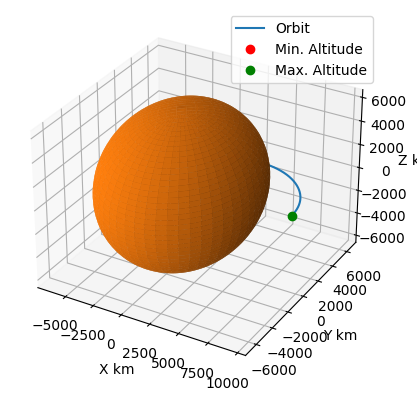

In [6]:
G = 6.67430e-20  # km**3/(kg * s**2)
m_1 = 5.97219e24  # kg
m_2 = 1000  # kg
mu = G * m_1
R_E = 6378.12  # km

r_0 = r_orbital # km
v_0 = v_orbital  # km/s
print(r_0, v_0)
Y_0 = np.hstack((r_0, v_0))

def relative_motion(t, Y):
    """Calculate the motion of a two-body system relative to $m_1$.

    The state vector ``Y`` should be in the order:

    1. Coordinates of $m_2$ relative to $m_1$
    2. Velocity components of $m_2$ relative to $m_1$
    """
    # Get the three position components
    r_vec = Y[:3]

    # Create the derivative vector and copy the velocities into it
    Ydot = np.zeros_like(Y)
    Ydot[:3] = Y[3:]

    # Calculate the accelerations
    r = np.sqrt(np.sum(np.square(r_vec)))
    a_vec = -mu * r_vec / r ** 3
    Ydot[3:] = a_vec

    return Ydot

t_0 = 0  # seconds
t_f = 30*60  # seconds
t_points = np.linspace(t_0, t_f, 1000)
sol = solve_ivp(relative_motion, [t_0, t_f], Y_0, t_eval=t_points)

Y = sol.y.T
r = Y[:, :3]  # km
v = Y[:, 3:]  # km/s

r_mag = np.sqrt(np.sum(np.square(r), axis=1))
# altitude is the distance above the surface of the Earth
altitude = r_mag - R_E

speed = np.sqrt(np.sum(np.square(v), axis=1))

min_altitude = np.min(altitude)
i_min = np.argmin(altitude)

max_altitude = np.max(altitude)
i_max = np.argmax(altitude)

speed_at_min_alt = speed[i_min]
speed_at_max_alt = speed[i_max]
time_at_min_alt = sol.t[i_min]
time_at_max_alt = sol.t[i_max]

print(
    f"""\
The minimum altitude during the orbit is: {min_altitude:.2F} km
The speed at the minimum altitude is: {speed_at_min_alt:.2F} km/s
The time at minimum altitude is: {time_at_min_alt:.2F} s
The maximum altitude during the orbit is: {max_altitude:.2F} km
The velocity at the maximum altitude is: {speed_at_max_alt:.4F} km/s
The time at maximum altitude is: {time_at_max_alt:.2F} s
"""
)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(r[:, 0], r[:, 1], r[:, 2], label="Orbit")
ax.set_xlabel("X km")
ax.set_ylabel("Y km")
ax.set_zlabel("Z km")

# This adds a sphere to the plot of the radius of the Earth
p = np.linspace(0, np.pi, 200)
t = np.linspace(0, 2 * np.pi, 200)
P, T = np.meshgrid(p, t)

X = R_E * np.cos(T) * np.sin(P)
Y = R_E * np.sin(T) * np.sin(P)
Z = R_E * np.cos(P)

ax.plot_surface(X, Y, Z)
ax.plot(r[i_min, 0], r[i_min, 1], r[i_min, 2], "ro", label="Min. Altitude")
ax.plot(r[i_max, 0], r[i_max, 1], r[i_max, 2], "go", label="Max. Altitude")
ax.legend()

# satelight position after 30 minutes
print('satelight position after 30 minutes: ', r[-1, 0], r[-1, 1], r[-1, 2])
# satelight velocity after 30 minutes
print('satelight velocity after 30 minutes: ', v[-1, 0], v[-1, 1], v[-1, 2])



